### Data Processing

#### Data Import

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib inline

## MAC Specific Command to run xgboost openMP without crashing Kernal
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

soil = pd.read_excel("data/Cody_soil_table.xlsx")
soil = soil.fillna(0)
soil = soil.transpose()
soil.head()

Populating the interactive namespace from numpy and matplotlib


,Hematite,Illmenite,Goethite,Magnetite,Quartz,Gibbsite,1:1 Clay,Maghemite,Carbonate Minerals,Plagioclase,2:1 Clays,Dolomite,Pyroxene,Calcite,Olivine,Glass,Interlayered Smectite,NTM Culture,Microbiome,Group
HNL 12-6,2.80702,0,4.08187,1.9883,0,0,6.78363,0.538012,38.5965,32.9825,0,0,6.4,0,5.1462,0,0,pos,1,Kitchen_sink
HNL 12-4,1.287,8.75161,7.72201,15.3153,7.72201,2.4453,33.3333,1.60875,21.879,0,0,0,0,0,0,0,0,pos,1,Laterite_carbonate
HNL 12-2,11.0457,3.24006,1.47275,0.206186,3.68189,7.65832,33.2842,0,21.0604,18.4094,0,0,0,0,0,0,0,pos,1,Laterite_carbonate_plagioclase
HNL 12-39,23.5402,7.22519,14.1907,2.86561,0.558272,7.94945,36.2554,7.41512,0,0,0,0,0,0,0,0,0,neg,1,Laterite
HNL 12-61,10.4787,3.44097,30.5982,12.063,5.16915,7.15495,24.8656,6.22948,0,0,0,0,0,0,0,0,0,neg,0,Laterite


#### Subsample Negative Response Variables
The subsampled dataframe used in the visualizations below is created to balance the response variable NTM Culture. There are 11 positive cultures and 42 negative samples. The resulting dataframe is normalized to 11 in each category.

In [29]:
## Randomly Subsample Negatives
grouped = soil.groupby('NTM Culture')
nmax = 11
import random
random.seed(1)
balanced = grouped.apply(lambda x: x.sample(nmax) if len(x) > nmax else x)

In [8]:
## User defined subsampling matching groups of positive culture status when availible
negatives_to_keep = ['BLD 12-1', 'HNL 12-40', 'HNL 12-46', 'HNL 12-39', 'HNL 12-30', 'HNL 12-55',
                     'HNL 12-51', 'HNL 12-23', 'HNL 12-60', 'HNL 12-17', 'HNL 12-44']

negative_groups = soil.loc[negatives_to_keep]
#negative_groups.merge(soil.loc[soil['NTM Culture']=='pos'])
positive_groups = soil.loc[soil['NTM Culture']=='pos']
balanced = pd.concat([positive_groups,negative_groups])

#### Scale Column Values
This process is used to normalize the values for machine learning algorithms and for visualization purposes. 

In [120]:
## Split data into numeric and categorial categories
cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
soil_numeric = balanced.drop(cols_to_drop, axis=1)
soil_categorical = balanced.drop(balanced.columns[0:16], axis=1)

## Store Columns and Index for later
cols = soil_numeric.columns
soil_index = soil_numeric.index

In [121]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_df = ss.fit_transform(soil_numeric)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
scaled_df.index = soil_index

soil_scaled = pd.merge(scaled_df, soil_categorical, left_index=True, right_index=True)
soil_scaled.head()

,Hematite,Illmenite,Goethite,Magnetite,Quartz,Gibbsite,1:1 Clay,Maghemite,Carbonate Minerals,Plagioclase,2:1 Clays,Dolomite,Pyroxene,Calcite,Olivine,Glass,Interlayered Smectite,NTM Culture,Microbiome,Group
HNL 12-6,-0.969936,-0.862575,-1.019200,-0.517364,-0.766483,-1.259642,-1.079896,-1.127474,1.725714,0.919181,-0.218218,0.0,0.67018,-0.218218,4.582576,0.0,0,pos,1,Kitchen_sink
HNL 12-4,-1.153871,2.013545,-0.627899,2.062031,0.494874,-0.378093,0.544153,-0.893663,0.669008,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,0,pos,1,Laterite_carbonate
HNL 12-2,0.027008,0.202235,-1.299669,-0.862286,-0.165063,1.501238,0.541150,-1.244956,0.617262,0.122221,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,0,pos,1,Laterite_carbonate_plagioclase
KAU 12-1,1.443715,0.303444,0.963094,1.800549,0.683179,0.777012,-0.764976,1.103743,-0.713959,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,0,pos,0,Laterite
HNL 12-22,0.019864,-0.159776,1.399426,-0.897079,-0.492991,-0.639307,1.035965,2.139348,-0.713959,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,0,pos,1,Laterite


In [122]:
x = soil_scaled[['NTM Culture']]

### Feature Correlation

#### Correlation between Features and Outcome Variable (Culture Status)

In [105]:
soil_categorical['NTM Culture'].replace(('pos', 'neg'), (1,0), inplace=True)
soil_response = list(soil_categorical['NTM Culture'])

In [106]:
from scipy import stats
correlation_pearson = []
names2 = []
for z in range(0, 16):
    value = stats.pointbiserialr(np.array(soil_scaled[soil_scaled.columns[z]]), soil_response)
    names2.append(soil_scaled.columns[z])
    correlation_pearson.append(value)

/Users/stronglab2/anaconda2/envs/Soil_Environment/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [107]:
Correlation = []
P_Value = []
x = [Correlation.append(x.correlation) for x in correlation_pearson]
x = [P_Value.append(x.pvalue) for x in correlation_pearson]
df_sig = pd.DataFrame(names2)
df_sig.columns = ['Soil_Minerals']
df_sig.set_index('Soil_Minerals')
df_sig['Correlation'] = Correlation
df_sig['P_Value'] = P_Value
df_sig

,Soil_Minerals,Correlation,P_Value
0,Hematite,-0.045006,0.842361
1,Illmenite,-0.130582,0.562440
2,Goethite,0.012575,0.955706
3,Magnetite,-0.149407,0.506937
4,Quartz,0.155784,0.488757
5,Gibbsite,0.028629,0.899360
6,1:1 Clay,-0.087245,0.699446
7,Maghemite,-0.259944,0.242688
8,Carbonate Minerals,0.052919,0.815074
9,Plagioclase,0.149425,0.506883


#### Significance of Features between groups

In [108]:
import numpy as np

def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / float(nmc)

In [109]:
positive = soil_scaled[soil_scaled['NTM Culture']=='pos']
negative = soil_scaled[soil_scaled['NTM Culture']=='neg']

cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
positive = positive.drop(cols_to_drop, axis=1)
negative = negative.drop(cols_to_drop, axis=1)

my_list = []
my_columns = []
for z in range(0, len(positive)):
    p_value = exact_mc_perm_test(np.array(positive[positive.columns[z]]), np.array(negative[negative.columns[z]]), 1000)
    my_columns.append(negative.columns[z])
    my_list.append(p_value)

In [110]:
df = pd.DataFrame(my_columns)
df['Permutated p_values'] = my_list
df

,0,Permutated p_values
0,Hematite,0.844
1,Illmenite,0.568
2,Goethite,0.951
3,Magnetite,0.516
4,Quartz,0.623
5,Gibbsite,0.896
6,1:1 Clay,0.725
7,Maghemite,0.246
8,Carbonate Minerals,0.808
9,Plagioclase,0.510


#### Test of Relation of Features Between Culture Groups

In [111]:
from scipy.stats import wilcoxon, shapiro, ttest_ind

pos_list = []
neg_list = []
my_columns = []

## Test if sample distribution per feature are normalily distributed
for i in range(len(positive.columns)):
    positive2 = shapiro(np.array(positive[positive.columns[i]]))
    negative2 = shapiro(np.array(negative[negative.columns[i]]))
    my_columns.append(negative.columns[i])
    pos_list.append(positive2[1])
    neg_list.append(negative2[1])

## Round to 2 significant figures    
pos_list = ['{:g}'.format(float('{:.2g}'.format(i))) for i in pos_list]
neg_list = ['{:g}'.format(float('{:.2g}'.format(i))) for i in neg_list]

## Combine Values to Matrix 
Normalilty_Matrix = pd.DataFrame(my_columns)
Normalilty_Matrix['Positive Normality'] = pos_list
Normalilty_Matrix['Negative Normality'] = neg_list
Normalilty_Matrix

## Warning likely due to the sample with glass and the sample with olivine, both are only present in one sample

/Users/stronglab2/anaconda2/envs/Soil_Environment/lib/python3.6/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,0,Positive Normality,Negative Normality
0,Hematite,0.34,0.58
1,Illmenite,0.0089,0.01
2,Goethite,0.34,0.46
3,Magnetite,0.00065,0.0062
4,Quartz,7.1e-05,0.061
5,Gibbsite,0.23,0.29
6,1:1 Clay,0.51,0.9
7,Maghemite,0.027,0.33
8,Carbonate Minerals,0.0018,0.00077
9,Plagioclase,0.034,0.0049


Normal Columns are defined by the table above in which both Positive and Negative Normality tests are greater than 0.05 failing to reject the null hypothesis that these are drawn from normally distributed samples. These columns will be tested with parameteric t-test, while the others will use a non-parametric wilcoxon test.


In [112]:
Normal_Columns = ['Glass', '1:1 Clay', 'Gibbsite', 'Goethite', 'Hematite', 'Dolomite']

## Subset Data Frames into Normal and NonNormal Columns
positive_norm = positive[Normal_Columns]
positive_non_norm = positive.drop(Normal_Columns, 1)

negative_norm = negative[Normal_Columns]
negative_non_norm = negative.drop(Normal_Columns, 1)

In [113]:
p_value_list = []

my_columns = []

## Run Nonparameteric Tests
for i in range(len(positive_non_norm.columns)):
    test = wilcoxon(np.array(positive_non_norm[positive_non_norm.columns[i]]), np.array(negative_non_norm[negative_non_norm.columns[i]]), zero_method="pratt")
    my_columns.append(negative_non_norm.columns[i])
    p_value_list.append(test.pvalue)
    
## Run Parametric Tests
for i in range(len(positive_norm.columns)):
    test = ttest_ind(np.array(positive_norm[positive_norm.columns[i]]), np.array(negative_norm[negative_norm.columns[i]]), equal_var=False)
    my_columns.append(negative_norm.columns[i])
    p_value_list.append(test.pvalue)

    
## Combine Values into Matrix 
Significance_Matrix = pd.DataFrame(my_columns)
Significance_Matrix['P_Value'] = p_value_list
Significance_Matrix.columns = ['Feature', 'P_Value']

Significance_Matrix

,Feature,P_Value
0,Illmenite,0.423596
1,Magnetite,0.373945
2,Quartz,0.858863
3,Maghemite,0.213223
4,Carbonate Minerals,0.533695
5,Plagioclase,0.423596
6,2:1 Clays,0.003346
7,Pyroxene,0.040860
8,Calcite,0.003346
9,Olivine,0.003346


#### Feature Heatmap

Text(0.5, 0.98, 'Soil Attributes Correlation Heatmap')

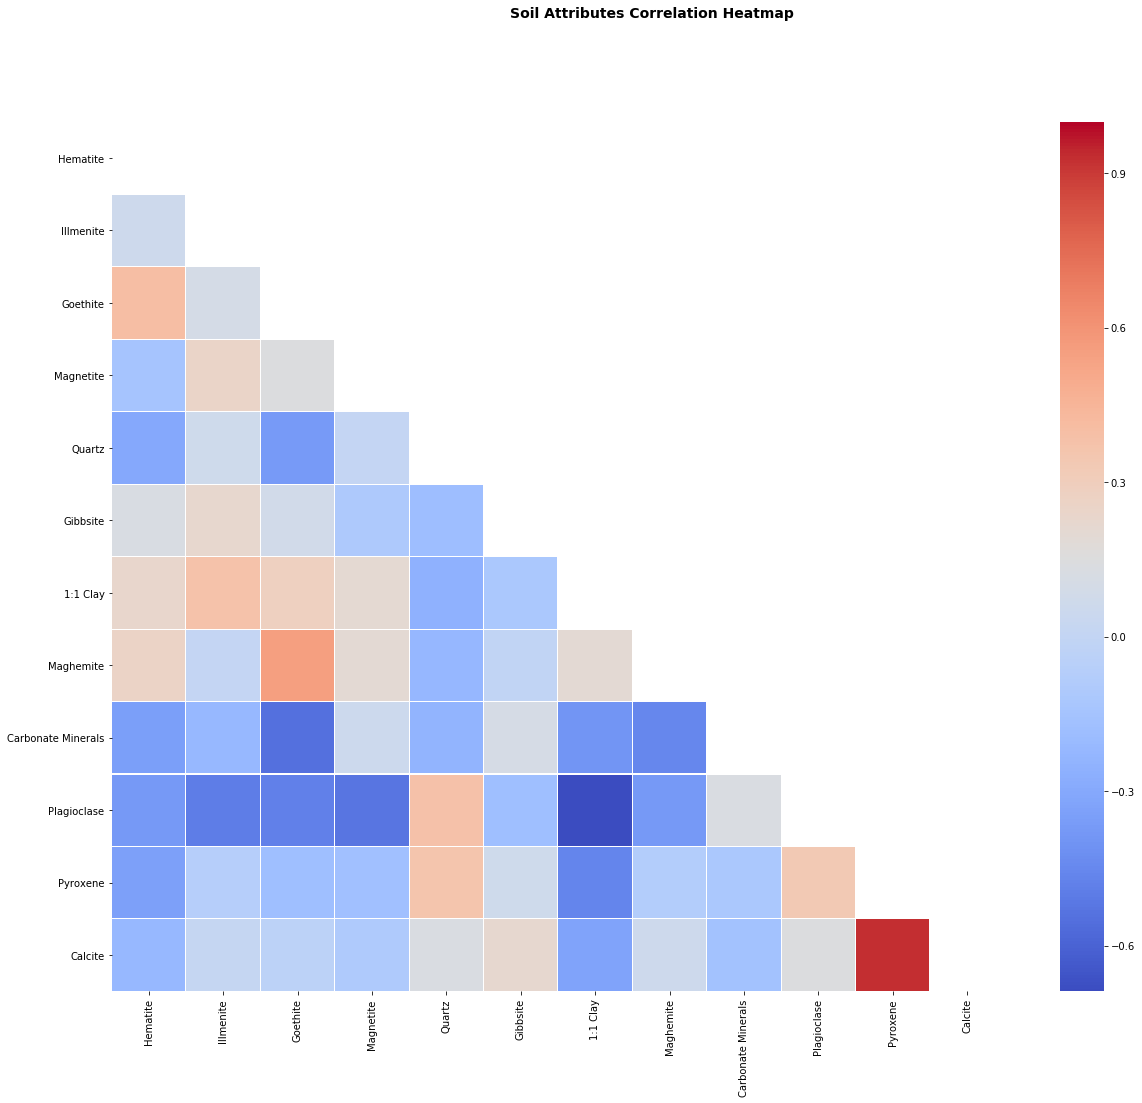

In [6]:
import seaborn as sns
import numpy as np

### Remove Empty Columns
Empty_Columns = ['Glass', '2:1 Clays', "Olivine", "Dolomite"]
soil_scaled2 = soil_scaled.drop(Empty_Columns, 1)

corr_matrix = soil_scaled2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, (ax) = plt.subplots(1, 1, figsize=(20,16))
hm = sns.heatmap(corr_matrix,
                 mask=mask,
                 ax=ax, # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=False,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=False, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)
fig.suptitle('Soil Attributes Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')

#### Parallel Coordinates

In [114]:
plt.rc('legend',**{'fontsize':12})
from pandas.plotting import parallel_coordinates

##### Balanced Dataset Full Samples

###### By NTM Culture

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 8 Text yticklabel objects>)

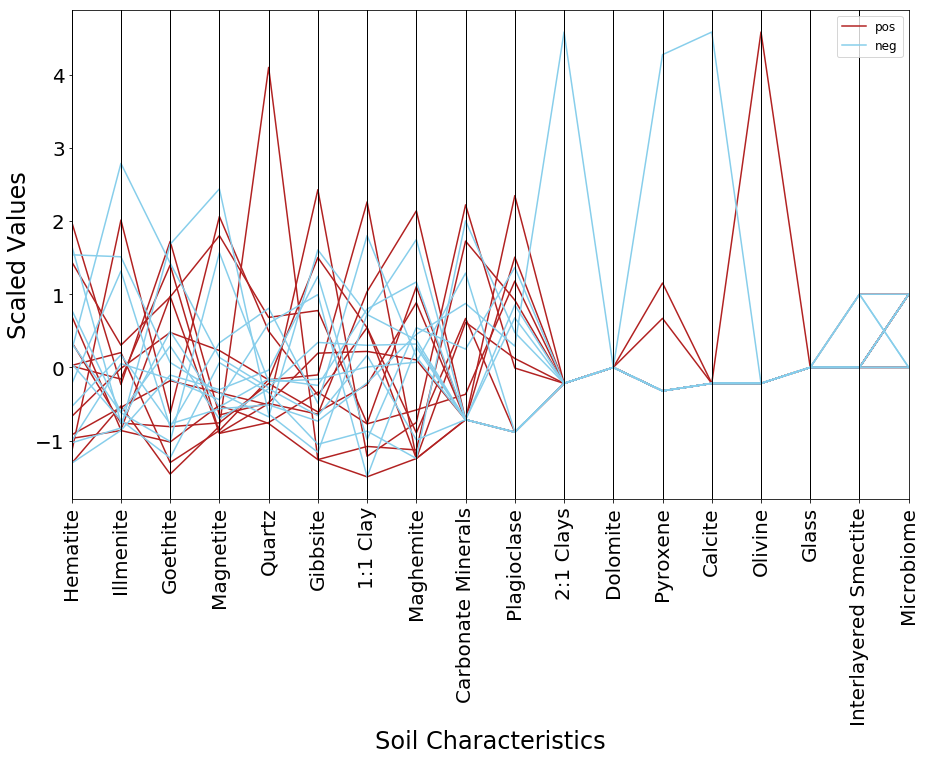

In [67]:
soil_scaled2 = soil_scaled.drop("Group", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'NTM Culture', 
                          color=('firebrick', 'skyblue'))
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Group

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 8 Text yticklabel objects>)

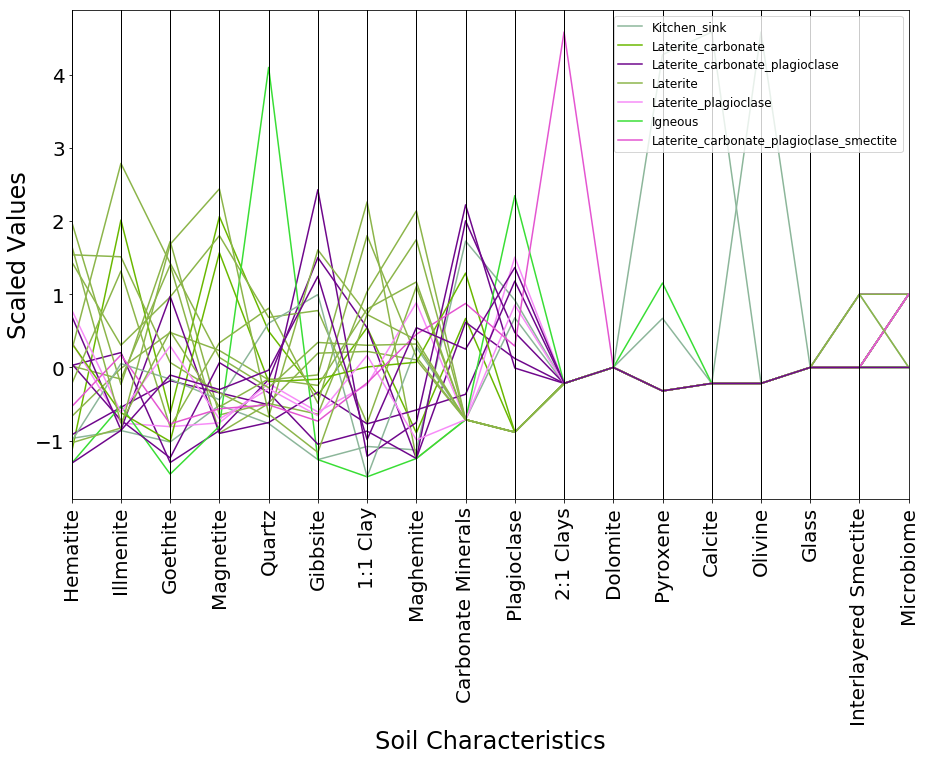

In [68]:
soil_scaled2 = soil_scaled.drop("NTM Culture", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Group')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Interlayered Smectite

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 8 Text yticklabel objects>)

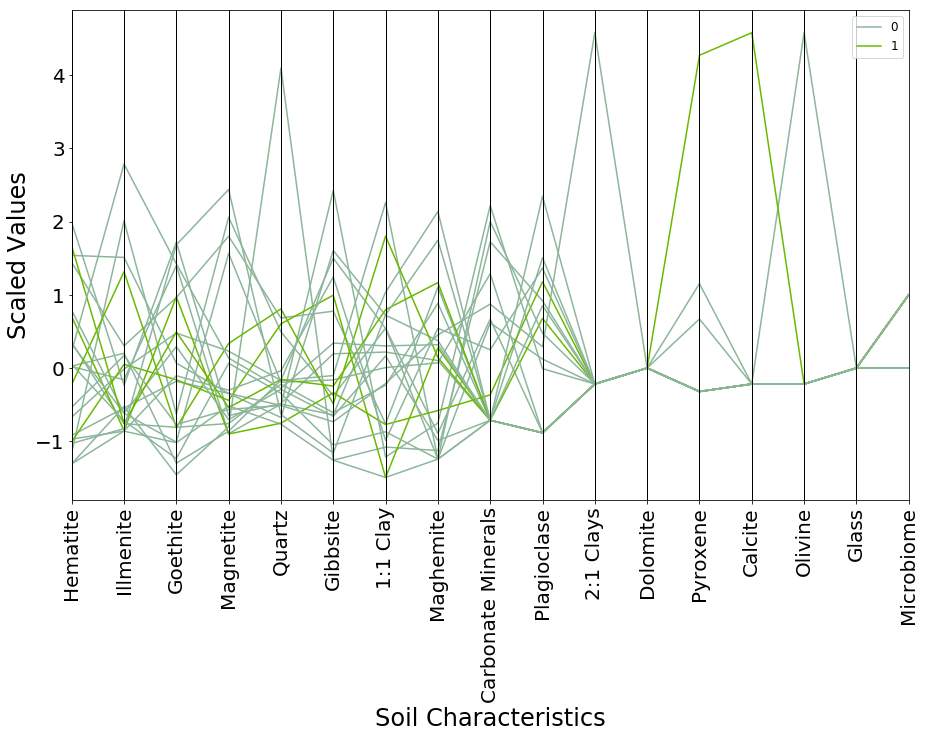

In [69]:
soil_scaled2 = soil_scaled.drop(["NTM Culture", "Group"], axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Interlayered Smectite')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

##### Balanced Dataset Showing Mean

In [115]:
culture_std = soil_scaled.groupby("NTM Culture").std()

culture_average = soil_scaled.groupby('NTM Culture').mean()
culture_average['NTM Culture'] = culture_average.index
#culture_average['NTM Culture'].replace(('pos', 'neg'), ('Positive Culture', 'Negative Culture'), inplace=True)


x_axis = list(culture_average.columns)
x_axis.pop()
x_axis = [str(x) for x in x_axis]

### means
negative_means = list(culture_average.iloc[0])
positive_means = list(culture_average.iloc[1])

negative_means.pop()
positive_means.pop()

negative_means = np.array(negative_means)
positive_means = np.array(positive_means)

### standard deviations
negative_std = np.array(culture_std.iloc[0])
positive_std = culture_std.iloc[1]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

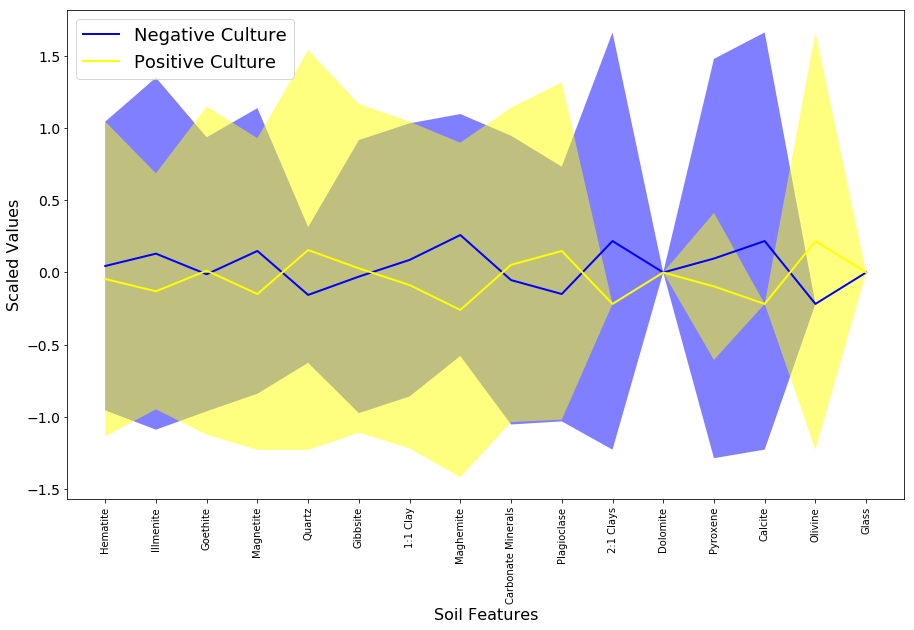

In [126]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(negative_means, lw=2, label='Negative Culture', color='blue')
plt.fill_between(x_axis, negative_means+negative_std, negative_means-negative_std, facecolor='blue', alpha=0.5)

ax.plot(positive_means, lw=2, label='Positive Culture', color='yellow')


plt.fill_between(x_axis, positive_means+positive_std, positive_means-positive_std, facecolor='yellow', alpha=0.5)
plt.legend(loc =2, prop={'size': 18})
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=14)
plt.xlabel("Soil Features", fontsize=16)
plt.ylabel("Scaled Values", fontsize=16)
plt.xticks(rotation=90) 

##### Full Data

In [130]:
## Reset Soil_Scaled to Full Dataset
## Split data into numeric and categorial categories
cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
soil_numeric = soil.drop(cols_to_drop, axis=1)
soil_categorical = soil.drop(balanced.columns[0:16], axis=1)

## Store Columns and Index for later
cols = soil_numeric.columns
soil_index = soil_numeric.index

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_df = ss.fit_transform(soil_numeric)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
scaled_df.index = soil_index

soil_scaled = pd.merge(scaled_df, soil_categorical, left_index=True, right_index=True)

###### By NTM Culuture Mean

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

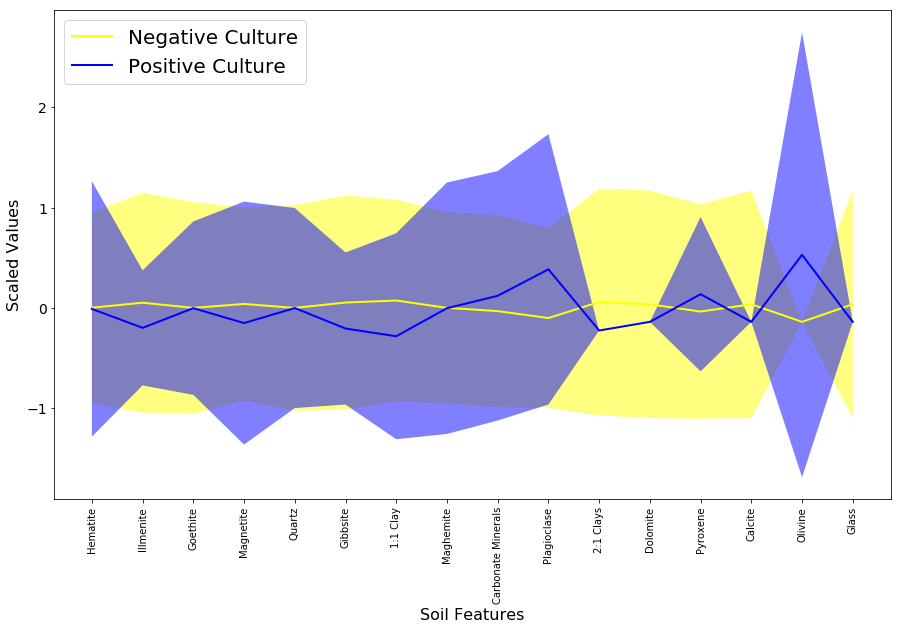

In [101]:
culture_std = soil_scaled.groupby("NTM Culture").std()

culture_average = soil_scaled.groupby('NTM Culture').mean()
culture_average['NTM Culture'] = culture_average.index
#culture_average['NTM Culture'].replace(('pos', 'neg'), ('Positive Culture', 'Negative Culture'), inplace=True)


x_axis = list(culture_average.columns)
x_axis.pop()
x_axis = [str(x) for x in x_axis]

### means
negative_means = list(culture_average.iloc[0])
positive_means = list(culture_average.iloc[1])

negative_means.pop()
positive_means.pop()

negative_means = np.array(negative_means)
positive_means = np.array(positive_means)

### standard deviations
negative_std = np.array(culture_std.iloc[0])
positive_std = culture_std.iloc[1]

# plot it!
fig, ax = plt.subplots(1)
ax.plot(negative_means, lw=2, label='Negative Culture', color='yellow')
plt.fill_between(x_axis, negative_means+negative_std, negative_means-negative_std, facecolor='yellow', alpha=0.5)

ax.plot(positive_means, lw=2, label='Positive Culture', color='blue')

plt.fill_between(x_axis, positive_means+positive_std, positive_means-positive_std, facecolor='blue', alpha=0.5)
plt.legend(loc ="upper left", prop={'size': 20})
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=14)
plt.xlabel("Soil Features", fontsize=16)
plt.ylabel("Scaled Values", fontsize=16)
plt.xticks(rotation=90) 

###### By NTM Culture

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

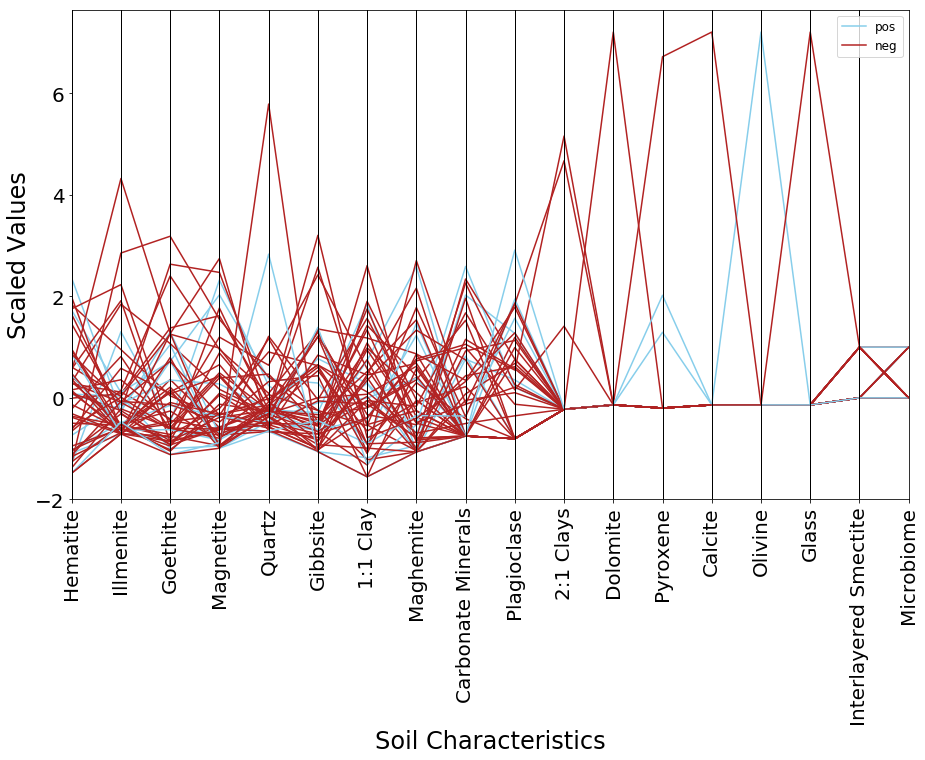

In [75]:
soil_scaled2 = soil_scaled.drop("Group", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'NTM Culture', 
                          color=('skyblue', 'firebrick'))
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Group

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

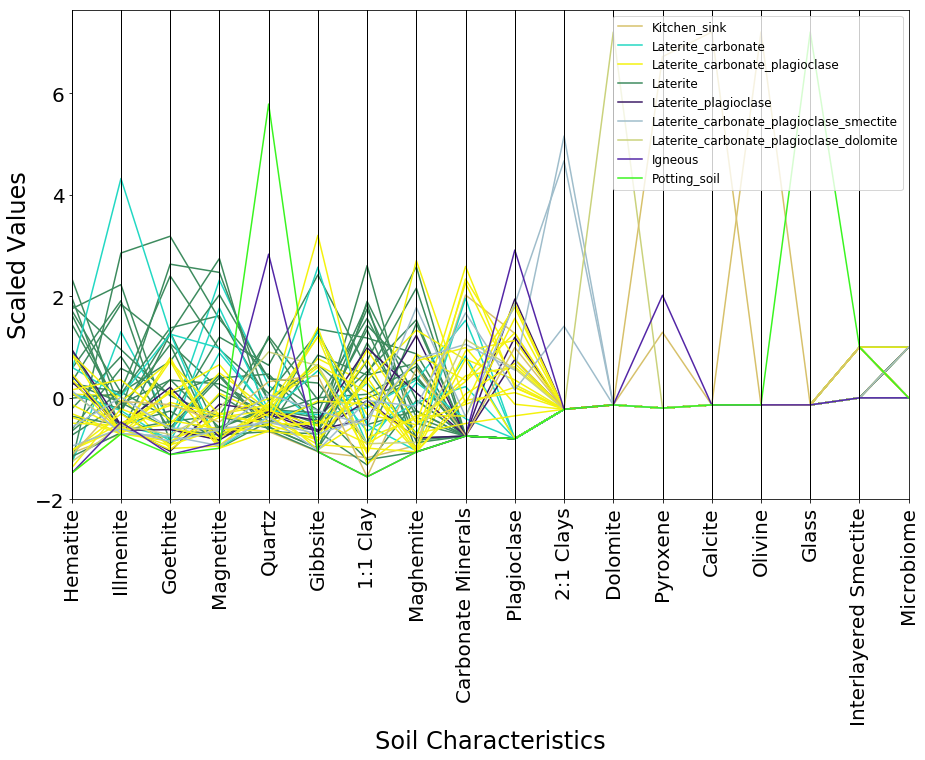

In [30]:
soil_scaled2 = soil_scaled.drop("NTM Culture", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Group')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Interlayered Smecite

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

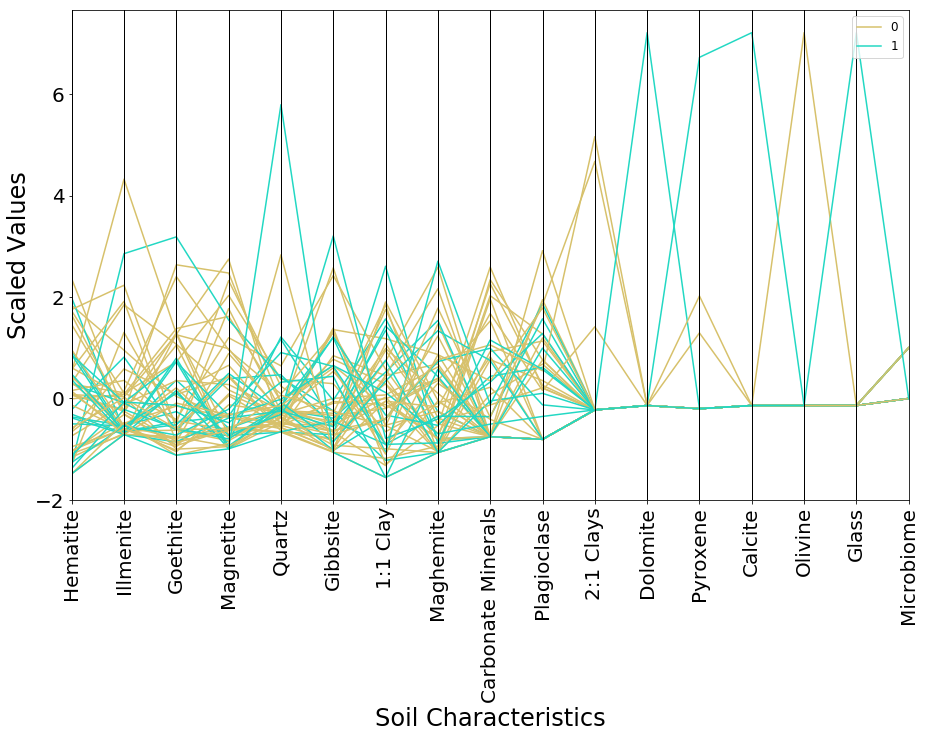

In [31]:
soil_scaled2 = soil_scaled.drop(["NTM Culture", "Group"], axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Interlayered Smectite')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

### Microbiome Analysis

#### Data Import and Munging

In [113]:
scaled_df['ID'] = scaled_df.index
scaled_df['Island'] = [x.split(' ')[0] for x in scaled_df['ID']]
scaled_df['SampleName'] = [x.split(' ')[1] for x in scaled_df['ID']]

### Filter By Island to Keep HNL
HNL_df = scaled_df.loc[scaled_df['Island']=='HNL']

### Import samples from Microbiome
NTM_Counts = pd.read_csv("data/NTM_Count_Bi.csv")
Microbiome_samples = list(NTM_Counts['SampleName'])
Microbiome_samples = [w.replace('_', '-') for w in Microbiome_samples]

### Filter Island Samples by Microbiome

df_microbiome = HNL_df.loc[HNL_df['SampleName'].isin(Microbiome_samples)]

## Check for missing samples in soil df
A = set(Microbiome_samples)
B = set(df_microbiome['SampleName'])
C = A-B

## Remove non-numeric columns
NTM_Counts['IDs'] = Microbiome_samples
cols_to_drop = ["Island"]
df_microbiome = df_microbiome.drop(cols_to_drop, axis=1)

### Merge NTM Counts Column
df_microbiome = pd.merge(df_microbiome, NTM_Counts, left_on='SampleName', right_on='IDs')
df_microbiome = df_microbiome.set_index('ID')

## Add in NTM Culture Statuses 
df_microbiome = pd.merge(df_microbiome, soil_categorical, left_index=True, right_index=True)
## Split data into numeric and categorial categories
cols_to_drop = ["Interlayered Smectite","Microbiome", "Group", "SampleName_y", "SampleName_x", "IDs"]
df_microbiome = df_microbiome.drop(cols_to_drop, axis=1)
df_microbiome.head()

,Hematite,Illmenite,Goethite,Magnetite,Quartz,Gibbsite,1:1 Clay,Maghemite,Carbonate Minerals,Plagioclase,2:1 Clays,Dolomite,Pyroxene,Calcite,Olivine,Glass,NTM_Counts_Categories,NTM Culture
HNL 12-6,-0.969936,-0.862575,-1.019200,-0.517364,-0.766483,-1.259642,-1.079896,-1.127474,1.725714,0.919181,-0.218218,0.0,0.67018,-0.218218,4.582576,0.0,High,pos
HNL 12-4,-1.153871,2.013545,-0.627899,2.062031,0.494874,-0.378093,0.544153,-0.893663,0.669008,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,Low,pos
HNL 12-2,0.027008,0.202235,-1.299669,-0.862286,-0.165063,1.501238,0.541150,-1.244956,0.617262,0.122221,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,High,pos
HNL 12-22,0.019864,-0.159776,1.399426,-0.897079,-0.492991,-0.639307,1.035965,2.139348,-0.713959,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,High,pos
HNL 12-57,-0.670540,-0.013686,0.477742,0.230742,-0.169855,-0.102394,2.261725,-1.244906,-0.713959,-0.884541,-0.218218,0.0,-0.32090,-0.218218,-0.218218,0.0,Low,pos


#### Correlation to Response

In [95]:
df_microbiome['NTM_Counts_Categories'].replace(('High', 'Low'), (1,0), inplace=True)
response = list(df_microbiome['NTM_Counts_Categories'])

cols_to_drop = ["NTM_Counts_Categories","NTM Culture"]
microbiome = df_microbiome.drop(cols_to_drop, axis=1)

from scipy import stats
correlation_pearson = []
names2 = []
for z in range(0, 16):
    value = stats.pointbiserialr(np.array(microbiome[microbiome.columns[z]]), response)
    names2.append(microbiome.columns[z])
    correlation_pearson.append(value)
    
Correlation = []
P_Value = []
x = [Correlation.append(x.correlation) for x in correlation_pearson]
x = [P_Value.append(x.pvalue) for x in correlation_pearson]
df_sig = pd.DataFrame(names2)
df_sig.columns = ['Soil_Minerals']
df_sig.set_index('Soil_Minerals')
df_sig['Correlation'] = Correlation
df_sig['P_Value'] = P_Value
df_sig

/Users/stronglab2/anaconda2/envs/Soil_Environment/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,Soil_Minerals,Correlation,P_Value
0,Hematite,3.651415e-02,0.901374
1,Illmenite,1.958233e-01,0.502263
2,Goethite,-3.472388e-02,0.906190
3,Magnetite,-3.492090e-01,0.221031
4,Quartz,1.069688e-02,0.971049
5,Gibbsite,2.493114e-01,0.390032
6,1:1 Clay,2.207220e-01,0.448275
7,Maghemite,9.690113e-02,0.741745
8,Carbonate Minerals,-1.880915e-01,0.519610
9,Plagioclase,-6.493264e-02,0.825454


#### Features Between Groups

In [96]:
from scipy.stats import wilcoxon, shapiro, ttest_ind

High = df_microbiome[df_microbiome['NTM_Counts_Categories']==1]
Low = df_microbiome[df_microbiome['NTM_Counts_Categories']==0]

cols_to_drop = ["NTM_Counts_Categories", "NTM Culture"]
High = High.drop(cols_to_drop, axis=1)
Low = Low.drop(cols_to_drop, axis=1)

high_list = []
low_list = []
my_columns = []

## Test if sample distribution per feature are normalily distributed
for i in range(len(High.columns)):
    High2 = shapiro(np.array(High[High.columns[i]]))
    Low2 = shapiro(np.array(Low[Low.columns[i]]))
    my_columns.append(Low.columns[i])
    high_list.append(High2[1])
    low_list.append(Low2[1])

## Round to 2 significant figures    
high_list = ['{:g}'.format(float('{:.2g}'.format(i))) for i in high_list]
low_list = ['{:g}'.format(float('{:.2g}'.format(i))) for i in low_list]

## Combine Values to Matrix 
Normalilty_Matrix = pd.DataFrame(my_columns)
Normalilty_Matrix['High Count Normality'] = high_list
Normalilty_Matrix['Low Count Normality'] = low_list
Normalilty_Matrix.set_index(0)

/Users/stronglab2/anaconda2/envs/Soil_Environment/lib/python3.6/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,High Count Normality,Low Count Normality
0,,
Hematite,0.83,0.72
Illmenite,0.4,0.011
Goethite,0.57,0.13
Magnetite,0.2,0.083
Quartz,0.14,0.27
Gibbsite,0.07,0.99
1:1 Clay,0.85,0.093
Maghemite,0.19,0.47
Carbonate Minerals,0.0069,0.14


In [97]:
Normal_Columns = ['Glass', 'Calcite', 'Dolomite', 'Maghemite', '1:1 Clay', 'Gibbsite', 
                  'Quartz', 'Magnetite', 'Goethite', 'Hematite']

## Subset Data Frames into Normal and NonNormal Columns
positive_norm = High[Normal_Columns]
positive_non_norm = High.drop(Normal_Columns, 1)

negative_norm = Low[Normal_Columns]
negative_non_norm = Low.drop(Normal_Columns, 1)

p_value_list = []

my_columns = []

## Run Nonparameteric Tests (Unequal Samples ## Need more to run)
'''for i in range(len(positive_non_norm.columns)):
    test = wilcoxon(np.array(positive_non_norm[positive_non_norm.columns[i]]), np.array(negative_non_norm[negative_non_norm.columns[i]]), zero_method="pratt")
    my_columns.append(negative_non_norm.columns[i])
    p_value_list.append(test.pvalue)
    '''
    
## Run Parametric Tests
for i in range(len(positive_norm.columns)):
    test = ttest_ind(np.array(positive_norm[positive_norm.columns[i]]), np.array(negative_norm[negative_norm.columns[i]]), equal_var=False)
    my_columns.append(negative_norm.columns[i])
    p_value_list.append(test.pvalue)

    
## Combine Values into Matrix 
Significance_Matrix = pd.DataFrame(my_columns)
Significance_Matrix['P_Value'] = p_value_list
Significance_Matrix.columns = ['Feature', 'P_Value']

Significance_Matrix

,Feature,P_Value
0,Glass,NaN
1,Calcite,0.075587
2,Dolomite,NaN
3,Maghemite,0.761476
4,1:1 Clay,0.447936
5,Gibbsite,0.463511
6,Quartz,0.973135
7,Magnetite,0.180862
8,Goethite,0.905414
9,Hematite,0.899701


#### Parallel Coordinates

In [98]:
df_microbiome = df_microbiome.drop("NTM Culture", 1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

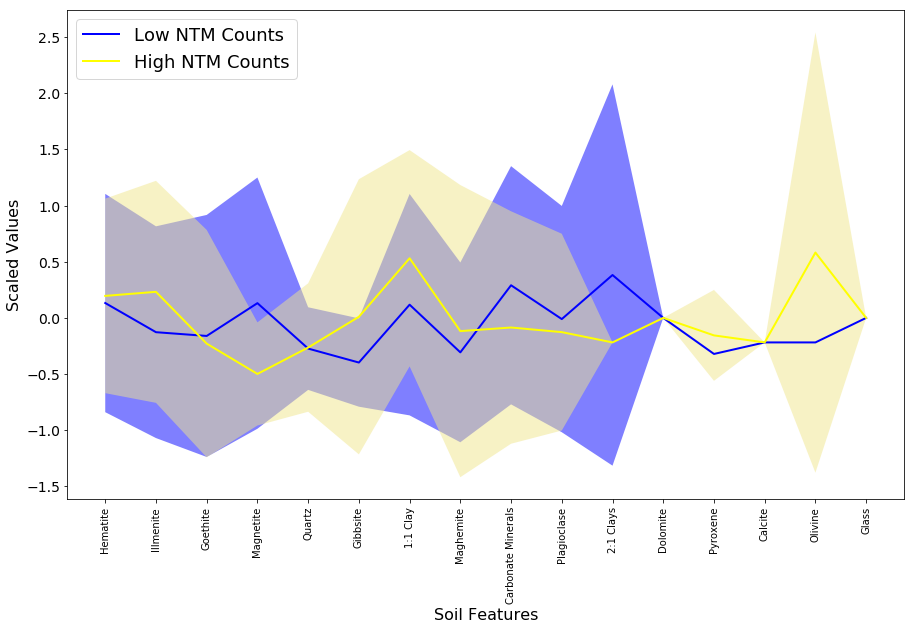

In [99]:
culture_std = df_microbiome.groupby("NTM_Counts_Categories").std()

culture_average = df_microbiome.groupby('NTM_Counts_Categories').mean()
culture_average['NTM_Counts_Categories'] = culture_average.index


x_axis = list(culture_average.columns)
x_axis.pop()
x_axis = [str(x) for x in x_axis]

### means
negative_means = list(culture_average.iloc[0])
positive_means = list(culture_average.iloc[1])

negative_means.pop()
positive_means.pop()

negative_means = np.array(negative_means)
positive_means = np.array(positive_means)

### standard deviations
negative_std = np.array(culture_std.iloc[0])
positive_std = culture_std.iloc[1]

# plot it!
fig, ax = plt.subplots(1)
ax.plot(negative_means, lw=2, label='Low NTM Counts', color='blue')
plt.fill_between(x_axis, negative_means+negative_std, negative_means-negative_std, facecolor='blue', alpha=0.5)

ax.plot(positive_means, lw=2, label='High NTM Counts', color='yellow')


plt.fill_between(x_axis, positive_means+positive_std, positive_means-positive_std, facecolor='khaki', alpha=0.5)
plt.legend(loc =2, prop={'size': 18})
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=14)
plt.xlabel("Soil Features", fontsize=16)
plt.ylabel("Scaled Values", fontsize=16)
plt.xticks(rotation=90) 

### Machine Learning Feature Selection

#### By Culture

In [144]:
## Split data into numeric and categorial categories
cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
soil_numeric = balanced.drop(cols_to_drop, axis=1)
soil_categorical = balanced.drop(balanced.columns[0:16], axis=1)

## Store Columns and Index for later
cols = soil_numeric.columns
soil_index = soil_numeric.index

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_df = ss.fit_transform(soil_numeric)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
scaled_df.index = soil_index

soil_scaled = pd.merge(scaled_df, soil_categorical, left_index=True, right_index=True)

cols_to_drop = ["Interlayered Smectite", "Microbiome", "Group"]
soil_scaled = soil_scaled.drop(cols_to_drop, axis=1)
soil_scaled['NTM Culture'].replace(('pos', 'neg'), (1, 0), inplace=True)
response = soil_scaled['NTM Culture']

# Save dataframe
#soil_scaled.to_csv("data/Balanced_with_Culture_Status.csv")
#soil_scaled

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text yticklabel objects>)

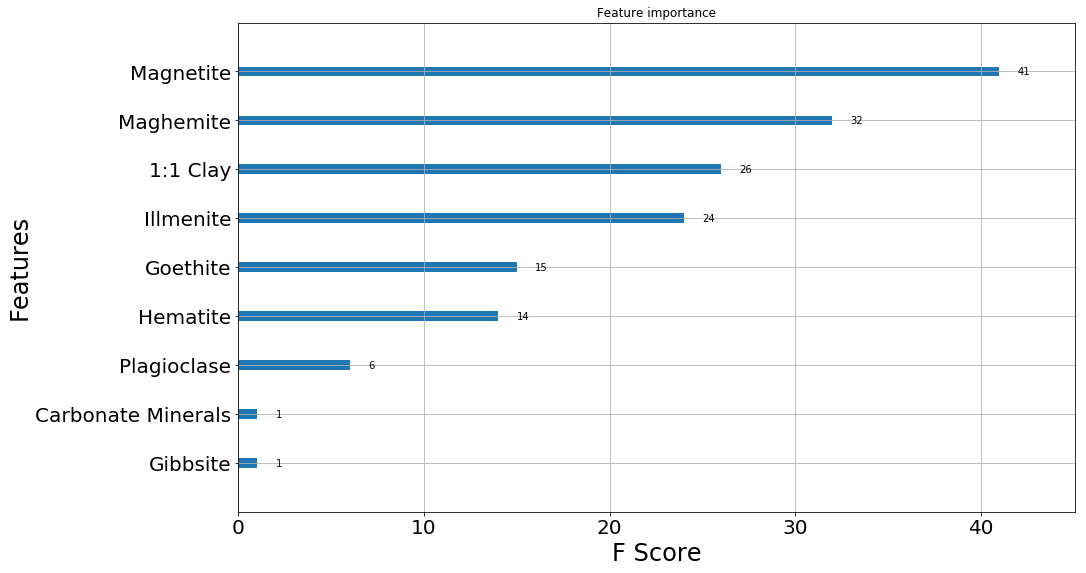

In [145]:
from xgboost import XGBClassifier
soil_scaled.pop('NTM Culture')

# fit model no training data
model = XGBClassifier(seed=1)
model.fit(soil_scaled, response)
from xgboost import plot_importance
plot_importance(model)
plt.xlabel('F Score', size = 24)
plt.ylabel('Features', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

In [146]:
importances = model.feature_importances_
df_import = pd.DataFrame(importances)
df_import.columns = ["Importance"]
df_import["Names"] = soil_scaled.columns.astype(str)
df_import.sort_values("Importance", ascending=False).head(10)

,Importance,Names
3,0.25625,Magnetite
7,0.20000,Maghemite
6,0.16250,1:1 Clay
1,0.15000,Illmenite
2,0.09375,Goethite
0,0.08750,Hematite
9,0.03750,Plagioclase
5,0.00625,Gibbsite
8,0.00625,Carbonate Minerals
4,0.00000,Quartz


#### By Count

In [127]:
response2 = list(df_microbiome['NTM_Counts_Categories'])

# Save dataframe
#df_microbiome.to_csv("data/Balanced_NTM_Counts.csv")

In [128]:
from xgboost import XGBClassifier
df_microbiome.pop('NTM_Counts_Categories')

# fit model no training data
model = XGBClassifier(seed=1)
model.fit(df_microbiome, response2)
from xgboost import plot_importance
plot_importance(model)
plt.xlabel('F Score', size = 24)
plt.ylabel('Features', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields NTM Culture

In [105]:
importances = model.feature_importances_
df_import = pd.DataFrame(importances)
df_import.columns = ["Importance"]
df_import["Names"] = df_microbiome.columns.astype(str)
df_import.sort_values("Importance", ascending=False).head(10)

,Importance,Names
6,0.396040,1:1 Clay
5,0.227723,Gibbsite
3,0.118812,Magnetite
2,0.108911,Goethite
4,0.069307,Quartz
7,0.069307,Maghemite
0,0.009901,Hematite
1,0.000000,Illmenite
8,0.000000,Carbonate Minerals
9,0.000000,Plagioclase


### Clustering Samples 

#### Culture

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the distance between each sample
Z = linkage(soil_scaled, 'ward')

soil_scaled = pd.merge(soil_scaled, x, left_index=True, right_index=True)


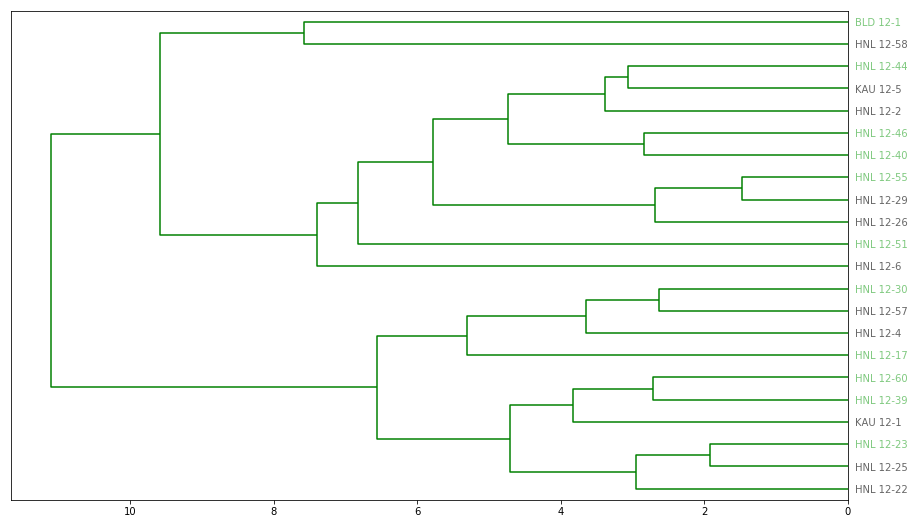

In [185]:
# Make the dendro
dendrogram(Z, labels=soil_scaled.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')
 
# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
soil_scaled['NTM Culture']=pd.Categorical(soil_scaled['NTM Culture'])
my_color=soil_scaled['NTM Culture'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()

for lbl in xlbls:
    q = str(lbl)
    name = q.split("'")[1]
    val=my_color[name]
    lbl.set_color(my_palette(val))

#### Microbiome Counts

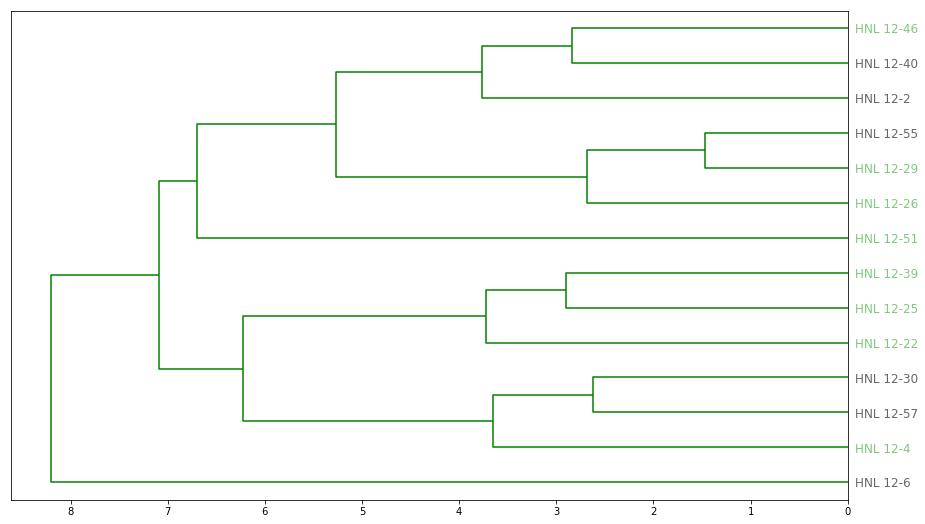

In [107]:
Z = linkage(df_microbiome, 'ward')
df_microbiome["NTM_Counts_Categories"] = response2
# Make the dendro
dendrogram(Z, labels=df_microbiome.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')
 
# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
df_microbiome['NTM_Counts_Categories']=pd.Categorical(df_microbiome['NTM_Counts_Categories'])
my_color=df_microbiome['NTM_Counts_Categories'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
